In [67]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# https://stackoverflow.com/questions/26873127/show-dataframe-as-table-in-ipython-notebook
from IPython.display import display, HTML, clear_output


## Data Preparation

In [3]:
# loading the dataset
# the dataset was scraped from https://www.enforcementtracker.com/
# and represents a public list of fines that 
# data protection authorities within the EU have imposed under the EU General Data Protection Regulation (GDPR, DSGVO).
df = pd.read_csv("./dataset_final.csv",index_col=0)

In [38]:
# veryifing completely duplicated rows in the case the scraping was wrong 
df.duplicated().sum()

0

In [39]:
# claryifying colum names
print(df.columns)
df.columns = ['country', 'agency', 'date_of_decision', 'fine_amount',
       'controller', 'sector', 'list_of_quoted_articles', 'type_of_fine', 'summary_of_case',
       'links']

Index(['country', 'agency', 'date_of_decision', 'fine_amount', 'controller',
       'sector', 'list_of_quoted_articles', 'type_of_fine', 'summary_of_case',
       'links'],
      dtype='object')


### cleaning fine_amount

In [6]:
cleaned_df = df.copy()

In [7]:
print(df['fine_amount'].dtype)
print(df['fine_amount'].value_counts())

object
fine_amount
2,000        153
5,000        128
3,000        126
10,000       110
1,000        103
            ... 
3,700,000      1
8,300          1
14,500         1
20,900         1
588            1
Name: count, Length: 481, dtype: int64


In [8]:
# used snippet of code found here https://stackoverflow.com/questions/22137723/convert-number-strings-with-commas-in-pandas-dataframe-to-float
# most of the fine amounts are in the format "7,000" so I replace "," with ""
# 141 rows have a non-numeric format 
df['fine_amount'] = df['fine_amount'].str.replace(',', '')
cleaned_df['fine_amount'] = cleaned_df['fine_amount'].str.replace(',', '')
rows_with_nan = pd.to_numeric(df['fine_amount'], errors='coerce')
rows_with_nan.isnull().sum()

141

In [9]:
# we have 2313 fine cases with defined numerical fine amount
cleaned_df.shape

(2454, 10)

In [10]:
# https://stackoverflow.com/questions/35682719/drop-rows-with-a-question-mark-value-in-any-column-in-a-pandas-dataframe
# Remove rows with any column having 'Unknown'
# df_any = df[~(df == 'Unknown').any(axis=1)]
# df_any.shape

In [11]:
# There are 96 rows with Unknown fine amount
# the other 45 rows are specified in range of value, not the actual value
# I'll remove all of those as there no imputation that can be done
print(df[rows_with_nan.isnull()]['fine_amount'].value_counts())
#print(df[ df['fine_amount'] == "Unknown"])


fine_amount
Unknown                                     96
Fine in four-digit amount                   10
Fine in three-digit amount                  10
Fine in five-digit amount                    9
Only intention to issue fine                 6
Fine amount between EUR 100 and EUR 1000     2
Fine amount between EUR 500 and EUR 4000     1
Fine amount between EUR 200 and EUR 1000     1
Fine in six-digit amount                     1
Fine amount between EUR 400 and EUR 600      1
Fine amount between EUR 300 and EUR 400      1
Fine amount between EUR 50 and EUR 100       1
Fine amount between EUR 350 and EUR 1000     1
Fine amount between EUR 50 and EUR 800       1
Name: count, dtype: int64


In [12]:
# we have 2313 fine cases with defined numerical fine amount
cleaned_df = cleaned_df[~(rows_with_nan.isnull())]
cleaned_df['fine_amount'] = pd.to_numeric(cleaned_df['fine_amount'])
cleaned_df.shape

(2313, 10)

In [47]:
cleaned_df["type_of_fine"].value_counts()

type_of_fine
Insufficient legal basis for data processing                                         660
Non-compliance with general data processing principles                               620
Insufficient technical and organisational measures to ensure information security    397
Insufficient fulfilment of data subjects rights                                      222
Insufficient fulfilment of information obligations                                   196
Insufficient cooperation with supervisory authority                                  124
Insufficient fulfilment of data breach notification obligations                       46
Insufficient involvement of data protection officer                                   22
Unknown                                                                               14
Insufficient data processing agreement                                                12
Name: count, dtype: int64

### cleaning list of quoted articles

In [13]:
print(cleaned_df[cleaned_df["list_of_quoted_articles"] == "Unknown"].shape)

(42, 10)


In [46]:
# using example from https://www.geeksforgeeks.org/python-pandas-apply/
#print(cleaned_df["list_of_quoted_articles"].unique()[0].count("Art."))
#for list_of_articles in cleaned_df["list_of_quoted_articles"].unique():
#   [[v for v in art.split(" ") if v][0] for art in list_of_articles.split("Art.") if len(art) > 0]
#    input()
# ['', ' 5 (1) f) GDPR, ', ' 32 (1) GDPR, ', ' 33 (1), (5) GDPR']
def clean_list(quoted_articles):
    articles = []
    if quoted_articles == "Unknown":
        return "{}"
    for article in quoted_articles.split("Art."):
        if article == '' or len(article) < 2:
            continue
        parts = [v for v in article.strip().split(" ") if v]
        article_number =  parts[0]
        articles.append(article_number)
    return str(set(articles))
cleaned_df["cleaned_quoted_articles"] = cleaned_df["list_of_quoted_articles"].apply(clean_list)

print(cleaned_df[["cleaned_quoted_articles","list_of_quoted_articles"]].head(5))

  cleaned_quoted_articles                            list_of_quoted_articles
0       {'32', '5', '33'}  Art. 5 (1) f) GDPR, Art. 32 (1) GDPR, Art. 33 ...
1                   {'6'}                                        Art. 6 GDPR
2            {'24', '32'}                         Art. 32 GDPR, Art. 24 GDPR
3  {'34', '33', '6', '9'}  Art. 6 (1) GDPR, Art. 9 (1) GDPR, Art. 33 (1) ...
4                  {'32'}                                   Art. 32 (1) GDPR


In [15]:
print(cleaned_df["list_of_quoted_articles"].head())
print(cleaned_df["cleaned_quoted_articles"].head())

0    Art. 5 (1) f) GDPR, Art. 32 (1) GDPR, Art. 33 ...
1                                          Art. 6 GDPR
2                           Art. 32 GDPR, Art. 24 GDPR
3    Art. 6 (1) GDPR, Art. 9 (1) GDPR, Art. 33 (1) ...
4                                     Art. 32 (1) GDPR
Name: list_of_quoted_articles, dtype: object
0         {'32', '5', '33'}
1                     {'6'}
2              {'24', '32'}
3    {'34', '33', '6', '9'}
4                    {'32'}
Name: cleaned_quoted_articles, dtype: object


In [53]:
print(cleaned_df["list_of_quoted_articles"].iloc[789])
print(cleaned_df["cleaned_quoted_articles"].iloc[789])

Art. 25 (1) GDPR, Art. 32 (1) b) GDPR, Art. 32 (2) GDPR
{'32', '25'}


### Creating Feature number of cited articles

In [19]:
#[quoted_articles.split(",") for quoted_articles in cleaned_df["list_of_quoted_articles"].value_counts().keys()]
def len_list(quoted_articles):
    return len(quoted_articles)
cleaned_df["n_quoted_articles"] = cleaned_df["list_of_quoted_articles"].apply(len_list)

### Creating Feature year of decision

In [20]:
# using snippet of code from https://stackoverflow.com/questions/59101883/convert-irregular-date-format-to-year-only-in-pandas
# There are only 18 fines with "Unknown" date of decision after processing the dates
# I noticed the index of all the 18 fines with "Unknown" values are in the bottom of the dataset
# since the dataset is ordered by date, it seems they are just before the earliest year 
# so i will attribute them to 2018 (the first year in the dataset)
cleaned_df['year'] = cleaned_df['date_of_decision'].astype(str).str.extract('(\d{4})').astype(str)
cleaned_df['year'] = pd.to_datetime(cleaned_df['year'], errors='coerce').dt.year
print(cleaned_df['year'].isnull())
fines_with_missing_date = cleaned_df[cleaned_df['year'].isnull()]
print(fines_with_missing_date['date_of_decision'].value_counts())
print(fines_with_missing_date['date_of_decision'].index.values)
# using a snippet from https://stackoverflow.com/questions/12307099/modifying-a-subset-of-rows-in-a-pandas-dataframe
cleaned_df.loc[fines_with_missing_date.index.values, 'year'] = 2018
print(cleaned_df['year'].value_counts())

0       False
1       False
2       False
3       False
4       False
        ...  
2557     True
2558     True
2559     True
2560     True
2561     True
Name: year, Length: 2313, dtype: bool
date_of_decision
Unknown    18
Name: count, dtype: int64
[2540 2541 2542 2543 2544 2545 2546 2547 2548 2553 2554 2555 2556 2557
 2558 2559 2560 2561]
year
2022.0    573
2023.0    527
2021.0    472
2020.0    359
2024.0    189
2019.0    163
2018.0     30
Name: count, dtype: int64


## Exploratory Data Analysis

### what are the dates intervals from the collected fines
    - latest    --  oldest with date
    - 2024-09-27 -- 2018-07-17

In [21]:
# first is the latest fine on the date of collection, -28 is the oldest fine with and decision
#   latest    --  oldest with date
#  2024-09-27 -- 2018-10-25
print(cleaned_df.iloc[0])
print(cleaned_df.iloc[-22])

country                                                              IRELAND
agency                                  Data Protection Authority of Ireland
date_of_decision                                                  2024-09-27
fine_amount                                                         91000000
controller                                    Meta Platforms Ireland Limited
sector                                      Media, Telecoms and Broadcasting
list_of_quoted_articles    Art. 5 (1) f) GDPR, Art. 32 (1) GDPR, Art. 33 ...
type_of_fine               Insufficient technical and organisational meas...
summary_of_case            The Irish DPA (DPC) has imposed a fine of EUR ...
links                      https://www.dataprotection.ie/en/news-media/pr...
cleaned_quoted_articles                                    {'32', '5', '33'}
n_quoted_articles                                                         59
year                                                                  2024.0

### analysing the frequency and distribution of Fines

In [22]:
# I create a pandas dataframe with quantile vvalues of the fines amount using:
# https://stackoverflow.com/questions/23833763/count-number-of-elements-in-each-column-less-than-x
#print(cleaned_df['fine_amount'].describe())
fine_amount_quantiles = pd.DataFrame({"fine_amount":cleaned_df['fine_amount'].quantile([0.05*i for i in range(1,20)])})
#fine_amount_quantiles['fine_amount'].quantile([0.05*i for i in range(1,20)]).apply(lambda v: cleaned_df['fine_amount'].lt(v).sum()))
fine_amount_quantiles["fines_less_than_amount"] = fine_amount_quantiles["fine_amount"].apply(lambda v: cleaned_df['fine_amount'].lt(v).sum())
fine_amount_quantiles["fines_greater_than_amount"] = fine_amount_quantiles["fine_amount"].apply(lambda v: cleaned_df['fine_amount'].gt(v).sum())
fine_amount_quantiles = fine_amount_quantiles.reset_index()
fine_amount_quantiles = fine_amount_quantiles.rename(columns={"index":"quantile"})
print(fine_amount_quantiles)


    quantile  fine_amount  fines_less_than_amount  fines_greater_than_amount
0       0.05        360.0                     113                       2196
1       0.10        600.0                     195                       2068
2       0.15       1000.0                     275                       1935
3       0.20       1500.0                     420                       1843
4       0.25       2000.0                     511                       1649
5       0.30       2500.0                     680                       1614
6       0.35       3000.0                     719                       1468
7       0.40       4000.0                     877                       1380
8       0.45       5000.0                     949                       1236
9       0.50       6900.0                    1156                       1156
10      0.55      10000.0                    1240                        963
11      0.60      13000.0                    1387                        923

['360', '600', '1000', '1500', '2000', '2500', '3000', '4000', '5000', '6900', '10000', '13000', '20000', '27039', '40000', '56000', '81600', '200000', '840400']
[2196, 2068, 1935, 1843, 1649, 1614, 1468, 1380, 1236, 1156, 963, 923, 750, 694, 576, 459, 347, 219, 116]


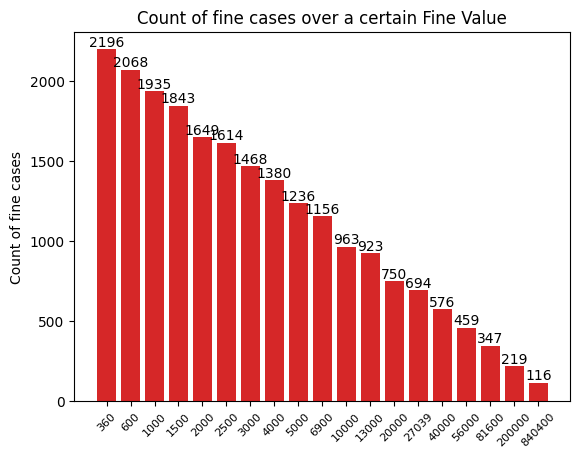

In [23]:
# adapted example from https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_colors.html#sphx-glr-gallery-lines-bars-and-markers-bar-colors-py
fig, ax = plt.subplots()

labels = [str(int(v)) for v in fine_amount_quantiles['fine_amount']]# fine_amount_quantiles['fine_amount'].values
counts = [v for v in fine_amount_quantiles['fines_greater_than_amount'].values]# fine_amount_quantiles['fines_greater_than_amount'].values
bar_labels = ['red' for v in labels] #'blue', '_red', 'orange']
bar_colors = ['tab:red' for v in labels]  #'tab:blue', 'tab:red', 'tab:orange']

bars = ax.bar(labels, counts, color=bar_colors)#label=bar_labels,)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5,  # 0.5 is offset for label placement
            f'{height}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, fontsize=8)  # Rotate x-axis labels by 45 degrees and set font size to 8
ax.set_ylabel('Count of fine cases')
ax.set_title('Count of fine cases over a certain Fine Value')
#ax.legend(title='Fruit color')

print(labels)
print(counts)
plt.show()


### analysing the top 10 highest of Fines 

#### All top 10 fines are over 90million euros

In [55]:
# sorting and selecting the top 10 fines
sorted_cleaned_df = cleaned_df.sort_values(by='fine_amount', ascending=False)
top_10_fines = sorted_cleaned_df.head(10)
print(top_10_fines[['controller','agency','country','sector','fine_amount']])

                             controller  \
532      Meta Platforms Ireland Limited   
1584        Amazon Europe Core S.à.r.l.   
955                Meta Platforms, Inc.   
711      Meta Platforms Ireland Limited   
369                      TikTok Limited   
12    Uber Technologies Inc., Uber B.V.   
827      Meta Platforms Ireland Limited   
1530              WhatsApp Ireland Ltd.   
0        Meta Platforms Ireland Limited   
1361                         Google LLC   

                                                 agency          country  \
532                Data Protection Authority of Ireland          IRELAND   
1584     National Commission for Data Protection (CNPD)       LUXEMBOURG   
955                Data Protection Authority of Ireland          IRELAND   
711                Data Protection Authority of Ireland          IRELAND   
369                Data Protection Authority of Ireland          IRELAND   
12    Dutch Supervisory Authority for Data Protectio...  THE NETHERLAN

In [54]:
top_10_fines

,country,agency,date_of_decision,fine_amount,controller,sector,list_of_quoted_articles,type_of_fine,summary_of_case,links,cleaned_quoted_articles,n_quoted_articles,year
532,IRELAND,Data Protection Authority of Ireland,2023-05-12,1200000000,Meta Platforms Ireland Limited,"Media, Telecoms and Broadcasting",Art. 46 (1) GDPR,Insufficient legal basis for data processing,The Irish DPA (DPC) has fined Meta Platforms I...,https://dataprotection.ie/en/news-media/press-...,{'46'},16,2023.0
1584,LUXEMBOURG,National Commission for Data Protection (CNPD),2021-07-16,746000000,Amazon Europe Core S.à.r.l.,Industry and Commerce,Unknown,Non-compliance with general data processing pr...,"In its quarterly report, Amazon.com Inc. annou...",https://www.sec.gov/ix?doc=/Archives/edgar/dat...,{},7,2021.0
955,IRELAND,Data Protection Authority of Ireland,2022-09-05,405000000,"Meta Platforms, Inc.","Media, Telecoms and Broadcasting","Art. 5 (1) a), c) GDPR, Art. 6 (1) GDPR, Art. ...",Non-compliance with general data processing pr...,The Irish DPA (DPC) has imposed a fine of EUR ...,https://edpb.europa.eu/system/files/2022-09/ed...,"{'6', '25', '5', '12', '24', '35'}",108,2022.0
711,IRELAND,Data Protection Authority of Ireland,2023-01-04,390000000,Meta Platforms Ireland Limited,"Media, Telecoms and Broadcasting","Art. 5 (1) a) GDPR, Art. 6 (1) GDPR, Art. 12 G...",Non-compliance with general data processing pr...,The Irish DPA (DPC) has fined Meta Platforms I...,https://dataprotection.ie/en/news-media/data-p...,"{'12', '13', '5', '6'}",70,2023.0
369,IRELAND,Data Protection Authority of Ireland,2023-09-01,345000000,TikTok Limited,"Media, Telecoms and Broadcasting","Art. 5 (1) c), 5 (1) f) GDPR, Art. 12 (1) GDPR...",Non-compliance with general data processing pr...,"The Irish DPA (DPC), has imposed a fine of EUR...",https://edpb.europa.eu/system/files/2023-09/fi...,"{'25', '24', '5', '12', '13'}",108,2023.0
12,THE NETHERLANDS,Dutch Supervisory Authority for Data Protectio...,2024-07-22,290000000,"Uber Technologies Inc., Uber B.V.",Employment,Art. 44 GDPR,Non-compliance with general data processing pr...,The Dutch DPA has imposed a fine of EUR 290 mi...,https://autoriteitpersoonsgegevens.nl/actueel/...,{'44'},12,2024.0
827,IRELAND,Data Protection Authority of Ireland,2022-11-25,265000000,Meta Platforms Ireland Limited,"Media, Telecoms and Broadcasting","Art. 25 (1), (2) GDPR",Insufficient technical and organisational meas...,The Irish DPA has fined Meta Platforms Ireland...,https://dataprotection.ie/en/news-media/press-...,{'25'},21,2022.0
1530,IRELAND,Data Protection Authority of Ireland,2021-09-02,225000000,WhatsApp Ireland Ltd.,"Media, Telecoms and Broadcasting","Art. 5 (1) a) GDPR, Art. 12 GDPR, Art. 13 GDPR...",Insufficient fulfilment of information obligat...,The Irish DPA (DPC) has imposed a fine of EUR ...,https://edpb.europa.eu/system/files/2021-09/dp...,"{'12', '13', '14', '5'}",60,2021.0
0,IRELAND,Data Protection Authority of Ireland,2024-09-27,91000000,Meta Platforms Ireland Limited,"Media, Telecoms and Broadcasting","Art. 5 (1) f) GDPR, Art. 32 (1) GDPR, Art. 33 ...",Insufficient technical and organisational meas...,The Irish DPA (DPC) has imposed a fine of EUR ...,https://www.dataprotection.ie/en/news-media/pr...,"{'32', '5', '33'}",59,2024.0
1361,FRANCE,French Data Protection Authority (CNIL),2021-12-31,90000000,Google LLC,"Media, Telecoms and Broadcasting",Art. 82 loi Informatique et Libertés,Insufficient legal basis for data processing,"On December 31, 2021, the French DPA (CNIL) im...",https://www.legifrance.gouv.fr/cnil/id/CNILTEX...,{'82'},36,2021.0


#### Are all top fines from "Big Tech"?

In [56]:
print(top_10_fines['sector'].value_counts())
print(top_10_fines.columns)
print(top_10_fines['controller'].value_counts())


sector
Media, Telecoms and Broadcasting    8
Industry and Commerce               1
Employment                          1
Name: count, dtype: int64
Index(['country', 'agency', 'date_of_decision', 'fine_amount', 'controller',
       'sector', 'list_of_quoted_articles', 'type_of_fine', 'summary_of_case',
       'links', 'cleaned_quoted_articles', 'n_quoted_articles', 'year'],
      dtype='object')
controller
Meta Platforms Ireland Limited       4
Amazon Europe Core S.à.r.l.          1
Meta Platforms, Inc.                 1
TikTok Limited                       1
Uber Technologies Inc., Uber B.V.    1
WhatsApp Ireland Ltd.                1
Google LLC                           1
Name: count, dtype: int64


#### What is the proportion of the sum of the top related to all fines ?


In [57]:
sum(top_10_fines['fine_amount'])/sum(cleaned_df['fine_amount'])

0.8063463801276145

### analysing the distribution of Fines over the years

#### Sum of Fines over the years




In [58]:
group_by_year = cleaned_df.groupby(by="year")["fine_amount"].agg(["count","sum"])
group_by_year["cumsum"] = np.cumsum(group_by_year["sum"])
group_by_year["cumcount"] = np.cumsum(group_by_year["count"])
print(group_by_year)

        count         sum      cumsum  cumcount
year                                           
2018.0     30      759024      759024        30
2019.0    163    72756964    73515988       193
2020.0    359   171770179   245286167       552
2021.0    472  1283677183  1528963350      1024
2022.0    573   842154165  2371117515      1597
2023.0    527  2080596542  4451714057      2124
2024.0    189   567220857  5018934914      2313


#### Is the median/mean of the fines increasing over the years?

### analysing the type of fines and quoted articles

In [59]:
cleaned_df["type_of_fine"].value_counts()

type_of_fine
Insufficient legal basis for data processing                                         660
Non-compliance with general data processing principles                               620
Insufficient technical and organisational measures to ensure information security    397
Insufficient fulfilment of data subjects rights                                      222
Insufficient fulfilment of information obligations                                   196
Insufficient cooperation with supervisory authority                                  124
Insufficient fulfilment of data breach notification obligations                       46
Insufficient involvement of data protection officer                                   22
Unknown                                                                               14
Insufficient data processing agreement                                                12
Name: count, dtype: int64

In [60]:
group_by_type_of_fine = cleaned_df.groupby(by="type_of_fine")["fine_amount"].agg(["sum"])
group_by_type_of_fine = group_by_type_of_fine.sort_values(by="sum", ascending=False)
total_sum = group_by_type_of_fine['sum'].sum()
group_by_type_of_fine['(%) percentage_of_total'] = round((group_by_type_of_fine['sum'] / total_sum) * 100,1)

display(HTML(group_by_type_of_fine.to_html()))


,sum,(%) percentage_of_total
type_of_fine,,
Non-compliance with general data processing principles,2410164850,48.0
Insufficient legal basis for data processing,1652915412,32.9
Insufficient technical and organisational measures to ensure information security,571027615,11.4
Insufficient fulfilment of information obligations,247864260,4.9
Insufficient fulfilment of data subjects rights,101006046,2.0
Unknown,23254800,0.5
Insufficient cooperation with supervisory authority,6639229,0.1
Insufficient fulfilment of data breach notification obligations,3977392,0.1
Insufficient data processing agreement,1117110,0.0


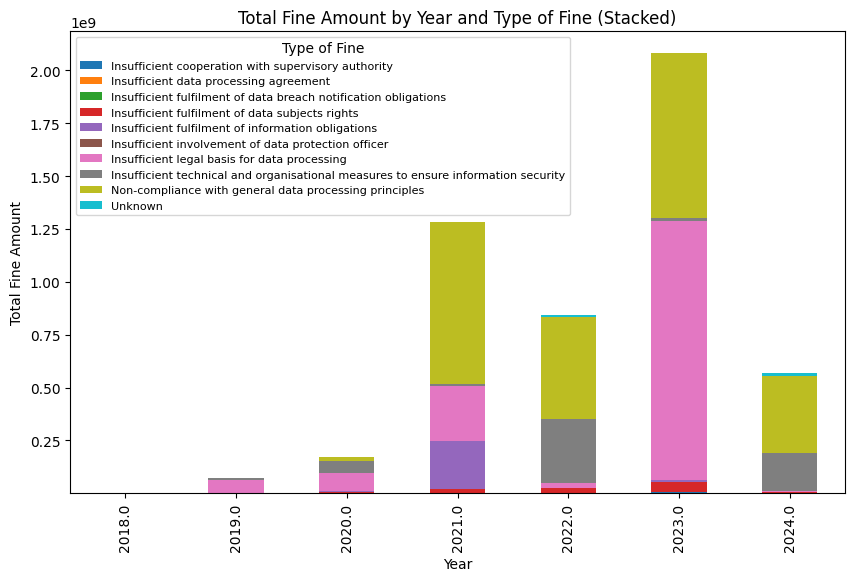

In [61]:
# Group by both 'type_of_fine' and 'year', then aggregate by the sum of 'fine_amount'
group_by_type_and_year = cleaned_df.groupby(by=["type_of_fine", "year"])["fine_amount"].agg(["sum"])

# Unstack the 'type_of_fine' to make each fine type a separate column
group_by_type_and_year_unstacked = group_by_type_and_year.unstack(level="type_of_fine")["sum"]

# Plot the stacked bar chart
group_by_type_and_year_unstacked.plot(kind="bar", stacked=True, figsize=(10, 6))

# Adding labels and title
plt.xlabel("Year")
plt.ylabel("Total Fine Amount")
plt.title("Total Fine Amount by Year and Type of Fine (Stacked)")
plt.legend(title="Type of Fine",fontsize=8, bbox_to_anchor=(0, 1), loc="upper left")

# Show the plot
plt.show()


#### what are frequent and impactful rights and violations ?



In [62]:

cleaned_df["cleaned_quoted_articles"].value_counts().head(10)

cleaned_quoted_articles
{'5'}           270
{'6'}           236
{'5', '6'}      171
{'32'}          157
{'32', '5'}     133
{'13'}          110
{'13', '5'}      91
{'58'}           85
{'12', '15'}     43
{}               42
Name: count, dtype: int64

In [63]:
group_by_quoted_articles = cleaned_df.groupby(by="cleaned_quoted_articles")["fine_amount"].agg(["sum","count"])
group_by_quoted_articles = group_by_quoted_articles.sort_values(by="sum", ascending=False)
total_sum = group_by_quoted_articles['sum'].sum()
group_by_quoted_articles['percentage_of_total'] = (group_by_quoted_articles['sum'] / total_sum) * 100

print(group_by_quoted_articles)

                                                           sum  count  \
cleaned_quoted_articles                                                 
{'46'}                                              1200000000      1   
{}                                                   775642080     42   
{'6', '25', '5', '12', '24', '35'}                   405000000      1   
{'12', '13', '5', '6'}                               390084200      5   
{'25', '24', '5', '12', '13'}                        345000000      1   
...                                                        ...    ...   
{'34', '5', '33', '28'}                                    321      1   
{'6', '17', '15', '5', '12'}                               290      1   
{'32', '13', '5', '6'}                                     200      1   
{'130', '31', '6', '25', '30', '24', '21', '5',...           0      1   
{'14', '6', '7', '12', '13'}                                 0      1   

                                                  

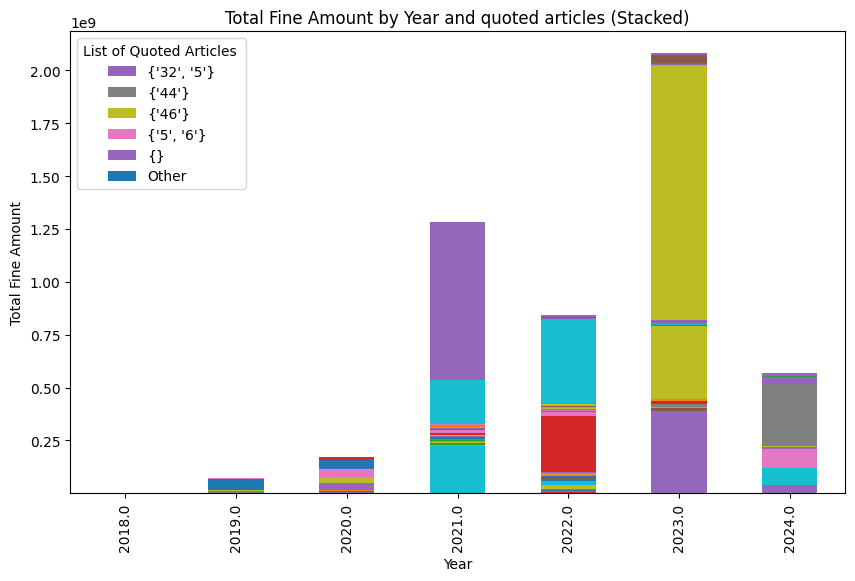

In [64]:

# Group by both 'type_of_fine' and 'year', then aggregate by the sum of 'fine_amount'
group_by_quoted_articles_and_year = cleaned_df.groupby(by=["cleaned_quoted_articles", "year"])["fine_amount"].agg(["sum"])

# Unstack the 'type_of_fine' to make each fine type a separate column
group_by_quoted_articles_and_year_unstacked = group_by_quoted_articles_and_year.unstack(level="cleaned_quoted_articles")["sum"]

# Plot the stacked bar chart
ax = group_by_quoted_articles_and_year_unstacked.plot(kind="bar", stacked=True, figsize=(10, 6))

# Adding labels and title
plt.xlabel("Year")
plt.ylabel("Total Fine Amount")
plt.title("Total Fine Amount by Year and quoted articles (Stacked)")

# Manually select the labels you want to show
selected_labels =  ["{'32', '5'}", "{'5', '6', '14', '13'}", "{'5', '6'}",'{}',
 "{'35', '5', '6', '24', '12', '25'}", "{'46'}", "{'44'}"]
colors = ['#FF5733']*len(selected_labels) #'#33FF57']  # Example colors for selected labels

# Get the current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Filter out the desired handles and labels (keep only selected labels)
filtered_handles = [handles[i] for i, label in enumerate(labels) if label in selected_labels]
filtered_labels = [label for label in labels if label in selected_labels]

# Assign the same color to all other labels
other_handles = [handles[i] for i, label in enumerate(labels) if label not in selected_labels]
other_labels = ['Other'] * 1  # Combine all non-selected labels as 'Other'

# Combine selected and non-selected items
final_handles = filtered_handles + other_handles
final_labels = filtered_labels + other_labels

# Apply new legend with colors
plt.legend(handles=final_handles, labels=final_labels, title="List of Quoted Articles ", fontsize=10, bbox_to_anchor=(0, 1), loc="upper left")

# Show the plot
plt.show()


In [65]:
group_by_quoted_articles_and_year_unstacked

cleaned_quoted_articles,"{'10', '6'}","{'11', '14', '13'}","{'11', '32', '28'}","{'113', '114', '5', '6'}","{'113', '5', '6', '88'}","{'114', '15', '5', '12', '13'}","{'114', '5', '88'}","{'114', '5'}","{'12', '11'}","{'12', '13', '14', '5'}",...,"{'8', '5', '6', '9'}","{'8', '5', '6'}","{'82', '5', '28'}","{'82', '6', '9', '5', '32', '28', '12', '13', '33'}",{'82'},"{'9', '18', '17', '16', '15', '5', '12', '32'}","{'9', '5', '28', '2-sexies', '2-septies', '32', '29'}","{'9', '5', '32', '12', '13'}",{'9'},{}
year,,,,,,,,,,,,,,,,,,,,,
2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30000.0,4100.0
2021.0,NaN,55000.0,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,225000000.0,...,NaN,2751000.0,NaN,NaN,210000000.0,NaN,NaN,NaN,600.0,747307300.0
2022.0,2000000.0,NaN,NaN,100000.0,12000.0,10000.0,NaN,3000.0,2000.0,720000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122000.0,8114480.0
2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50000.0,NaN,NaN,...,332000.0,NaN,125000.0,150000.0,NaN,10000.0,176000.0,NaN,50000.0,6125400.0
2024.0,NaN,NaN,NaN,NaN,NaN,NaN,5000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300000.0,NaN,14090300.0


In [66]:
print(group_by_quoted_articles_and_year_unstacked.max(axis=1),group_by_quoted_articles_and_year_unstacked.idxmax(axis=1).values)

year
2018.0    4.000000e+05
2019.0    5.000000e+07
2020.0    3.801303e+07
2021.0    7.473073e+08
2022.0    4.050000e+08
2023.0    1.200000e+09
2024.0    2.900000e+08
dtype: float64 ["{'32', '5'}" "{'5', '14', '13', '6'}" "{'5', '6'}" '{}'
 "{'6', '25', '5', '12', '24', '35'}" "{'46'}" "{'44'}"]
